In [18]:
import numpy as np
from numpy.linalg import inv # for matrix inverse on np.array objects, equals to np.matrix.I
import matplotlib.pyplot as plt
import scipy.signal as sps # for autocorrelation calculation
import math # for pi

In [28]:
# covariance of the stochastic gradient noise, V in the paper
covSGN = 1

# covariance matrix
rho = 0.9
# np.array object, not the subclass--np.matix (specialized 2-D array), so * is not permitted for matrix multiplication later
covM = np.array([[1,rho],[rho,1]]) 
invM = inv(covM)
# inverse covariance matrix, still np.array object
# invM = array([[ 5.26315789, -4.73684211],
#               [-4.73684211,5.26315789]])

# intial position in 2D format, x = [0;0] in matlab, which means a size(2,1) matrix 
theta = np.array([[0],[0]]) 

# dimension of the position theta, here is 2 for bivariate Gaussian
dimT = len(theta)

# this is highest learning rate value tried so far for SGLD that does not diverge
etaSGLD = 0.05
etaSGHMC = 0.05
alpha = 0.035

# First 50 samples of SGHMC and SGLD.
nStep = 50

# gradUNoise for function as follows:
probUMap = lambda X = None,Y = None: np.exp(- 0.5 * (np.multiply(X,X) * invM[0,0] + 2 * np.multiply(X,Y) * invM[0,1] + np.multiply(Y,Y) * invM[1,1])) / (2 * math.pi * np.sqrt(np.abs(np.linalg.det(covM))))
funcU = lambda x = None: 0.5 * np.dot(np.dot(np.transpose(x), invM), x) 
gradUTrue = lambda x = None: np.dot(invM, x)
gradUNoise = lambda x = None: np.dot(invM, x) + np.random.randn(2,1)

# set random seed
np.random.seed(20)



In [36]:
## SGLD using gradUNoise, for nStep steps, starting at position theta, use SGFS way to take noise gradient level into account,
## return data: array of positions

def sgld(gradU = None, eta = None, nStep = None, theta = None, covSGN = None): 
    
    # record the samples, the positions/theta
    samples = np.zeros((dimT, nStep))
    
    # diffusion matrix contributed by gradient noise, true stochastic gradient noise
    beta = covSGN * eta * 0.5 
    
    if beta > 1:
        raise Exception('too big eta')
    
    sigma = np.sqrt(2 * eta * (1 - beta))
    
    # do leapfrog
    for i in range(nStep):
        dtheta = - gradU(theta) * eta + np.random.randn(2,1) * sigma
        theta = theta + dtheta  # theta shape: 2D (2,1)
        samples[:,[i]] = theta
        
    return samples

In [37]:
## SGHMC using gradUNoise, for nStep steps, starting at position theta
## return data: array of positions

def sghmc(gradU = None,eta = None, nStep = None, alpha = None, theta = None, covSGN = None): 
    
    # record the samples, the positions/theta
    samples = np.zeros((dimT, nStep))
    
    # diffusion matrix contributed by gradient noise, true stochastic gradient noise
    beta = covSGN * eta * 0.5 
    
    if beta > alpha:
        raise Exception('too big eta')
    
    sigma = np.sqrt(2 * eta * (alpha - beta))
    r = np.random.randn(dimT, 1) * np.sqrt(eta)
    momentum = 1 - alpha
    
    # do leapfrog
    for i in range(nStep):
        r = r * momentum - gradU(theta) * eta + np.random.randn(2,1) * sigma
        theta = theta + r
        samples[:,[i]] = theta

    return samples

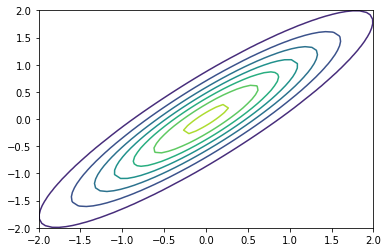

In [35]:
# build meshgrid
XX,YY = np.meshgrid(np.linspace(-2, 2),np.linspace(-2, 2))
ZZ = probUMap(XX,YY)

(-2.1, 2.5, -2.1, 2.5)

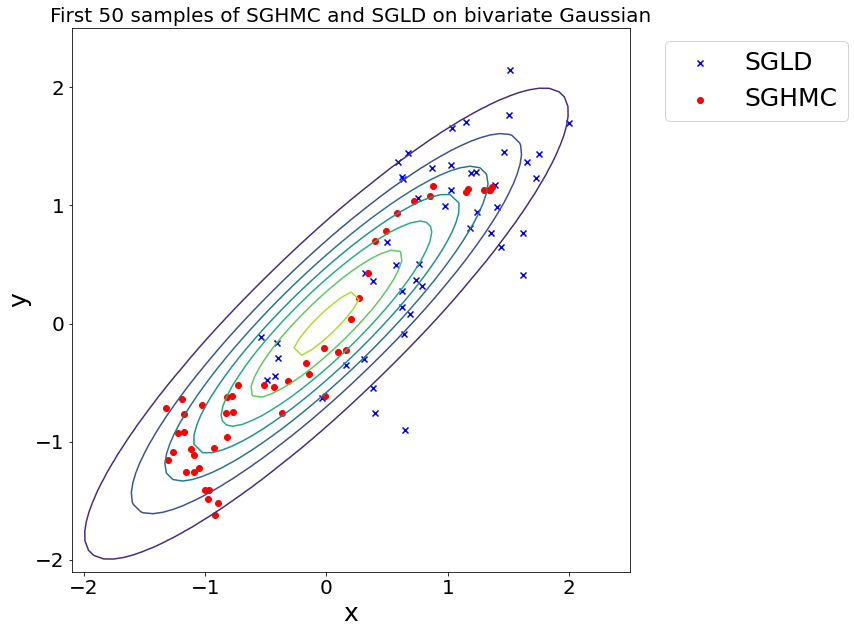

In [81]:
# draw the first samples
plt.title('First 50 samples of SGHMC and SGLD on bivariate Gaussian', fontsize=20) # title of the fig
plt.rcParams["figure.figsize"] = [10, 10] # the image size: width, length
plt.xlabel('x', fontsize=25)  # the x axis label name
plt.ylabel('y', fontsize=25)  # the x axis label name
plt.tick_params(axis='x', labelsize=20) # the x axis label size
plt.tick_params(axis='y', labelsize=20) # the y axis label size

dsgld = sgld(gradUNoise, etaSGLD, nStep, theta, covSGN)
dsghmc = sghmc(gradUNoise, etaSGHMC, nStep, alpha, theta, covSGN)

h1 = plt.scatter(dsgld[0,:],dsgld[1,:], c='b', marker='x', label='SGLD')
h2 = plt.scatter(dsghmc[0,:],dsghmc[1,:],c='r', marker='o',label='SGHMC')
plt.contour(XX,YY,ZZ)
plt.xlabel('x')
plt.ylabel('y')

plt.legend(np.array([h1,h2]),np.array(['SGLD','SGHMC']),bbox_to_anchor=(1.04,1), loc="upper left", fontsize=25)
plt.savefig('./Fig3/Fig3_First50Samples.jpg', bbox_inches='tight')
plt.axis(np.array([-2.1, 2.5, -2.1, 2.5]))